In [ ]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from timeit import default_timer as timer
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import helperfunction as hf
import cnn_models as cnn

In [2]:
#Set GPU Allocation
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1738848487.698344     649 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## ACCESS IMAGES IN THE DIRECTORY

In [ ]:
# Define the directory for images
#partial_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Dataset Images\\Rice Bran\\Raw'
partial_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Raw/Set 2'

# Define the subdirectories for each fabric type
pure_dir = os.path.join(partial_dir, 'Pure')
adulterated_dir = os.path.join(partial_dir, 'Adulterated')

# display sample image
image_path = os.path.join(adulterated_dir, 'adulterated_rb (5).jpg')
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


# Pre-process Images

In [11]:
# get images in each directory
def process_one_image(directory, output_path, img_index, class_name, kernel_num, limit_num):
    # Get a list of files in the directory, sorted by filename
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('(')[1].split(')')[0]))

    for filename in files:
        if f'{class_name} ({img_index}).jpg' in filename and img_index <= limit_num:
            filepath = os.path.join(directory, filename)
            # print(filepath)
            # print(type(filepath))
            # print(type(filepath))
            
            if os.path.isfile(filepath):
                # Load the image
                img_samp = cv2.imread(filepath)

                if img_samp is not None:
                    # Extract RGB channels
                    r_channel = img_samp[:, :, 2]
                    g_channel = img_samp[:, :, 1]
                    b_channel = img_samp[:, :, 0]

                    # convert to gray image
                    gray_img = np.uint8((0.299 * r_channel)) + np.uint8((0.587 * g_channel)) + np.uint8((0.114 * b_channel))

                    # threshold image
                    thres_img = hf.segment_img(gray_img)

                    # Define a rectangular structuring element (kernel)
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_num, kernel_num))
                    
                    # Clean thresholded image
                    opened_img = cv2.morphologyEx(thres_img, cv2.MORPH_OPEN, kernel)

                    # Make the thresholded image into a 500 x 500 resolution
                    final_img = hf.extract_and_resize_foreground(img_samp, opened_img)

                    # Create the output folder if it doesn't exist
                    os.makedirs(output_path, exist_ok=True)

                    image_name = f'image ({img_index}).jpg'
                    img_index += 1
                    path = os.path.join(output_path, image_name)
                    cv2.imwrite(path, final_img)
                else:
                    print(f"Error: Unable to load {filename}")

# get images in each directory
def process_two_image(directory, output_path, img_index, class_name, limit_num):
    # Get a list of files in the directory, sorted by filename
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('(')[1].split(')')[0]))

    for filename in files:
        if f'{class_name} ({img_index}).jpg' in filename and img_index <= limit_num:
            filepath = os.path.join(directory, filename)
            # print(filepath)
            # print(type(filepath))
            # print(type(filepath))
            
            if os.path.isfile(filepath):
                # Load the image
                img_samp = cv2.imread(filepath)

                if img_samp is not None:
                    # Make the thresholded image into a 500 x 500 resolution
                    final_img = hf.resize_img(img_samp)

                    # Create the output folder if it doesn't exist
                    os.makedirs(output_path, exist_ok=True)

                    image_name = f'image ({img_index}).jpg'
                    img_index += 1
                    path = os.path.join(output_path, image_name)
                    cv2.imwrite(path, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
                    
                else:
                    print(f"Error: Unable to load {filename}")

In [12]:
# initialize kernel
default_kernel = 5

# adulterated_output_folder_path = rf'C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Processed\Adulterated'
# pure_output_folder_path = rf'C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Processed\Pure'

# adulterated_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Adulterated'
# pure_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Pure'

# process_one_image(adulterated_dir, adulterated_output_folder_path, 1, 'adulterated_rb', default_kernel, 500)
# process_one_image(pure_dir, pure_output_folder_path, 1, 'pure_rb', default_kernel, 500)

adulterated_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 3/Adulterated'
pure_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 3/Pure'

process_two_image(adulterated_dir, adulterated_output_folder_path, 1, 'adulterated_rb', 500)
process_two_image(pure_dir, pure_output_folder_path, 1, 'pure_rb', 500)

### For depicted image

In [15]:
# Saving image that don't need high kernel
# Adulterated
changed_kernel_1 = 3
process_one_image(adulterated_dir, adulterated_output_folder_path, 241, 'adulterated_rb', changed_kernel_1, 260)


# Pure
# changed_kernel_2 = 5
# process_image(pure_dir, pure_output_folder_path, 301, 'pure_rb', changed_kernel_2, 420)

### Transfer Images for Training and Testing

In [ ]:
aduterated_sourcepath_1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Adulterated'
pure_sourcepath_1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Pure'

aduterated_sourcepath_2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 3/Adulterated'
pure_sourcepath_2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 3/Pure'

# hf.transfer_image_train_and_test(aduterated_sourcepath_1, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 2/Adulterated', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 2/Adulterated')

# hf.transfer_image_train_and_test(pure_sourcepath_1, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 2/Pure', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 2/Pure')

# hf.transfer_image_train_and_test(aduterated_sourcepath_2, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3/Adulterated', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3/Adulterated')

hf.transfer_image_train_and_test(pure_sourcepath_2, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3/Pure', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3/Pure')

### Data Augmentation

In [ ]:
dir1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 2'
dir2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3'

# Define the subdirectories for each type
pure_dir1 = os.path.join(dir1, 'Pure')
adulterated_dir1 = os.path.join(dir1, 'Adulterated')

pure_dir2 = os.path.join(dir2, 'Pure')
adulterated_dir2 = os.path.join(dir2, 'Adulterated')

hf.img_augmentation(pure_dir1)
hf.img_augmentation(adulterated_dir1)

hf.img_augmentation(pure_dir2)
hf.img_augmentation(adulterated_dir2)

## EXPERIMENT PART(IGNORE FOR NOW)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
#img_samp = cv2.imread(rf"C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Raw\Pure\pure_rb (21).jpg", cv2.COLOR_BGR2RGB)
#img_samp = cv2.imread(rf"C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Program\Dataset Images\Rice Bran\Raw\Adulterated\adulterated_rb (125).jpg", cv2.COLOR_BGR2RGB)

#img_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Raw/Set 2/Adulterated/adulterated_rb (1)'
img_samp = cv2.imread(image_path)

thres_img = hf.segment_img(img_samp)

# img_rgb = cv2.cvtColor(thres_img, cv2.COLOR_BGR2RGB)

axes[0].imshow(thres_img)
axes[0].set_title("Image")
axes[0].axis('off')

#Extract RGB channels
r_channel = img_samp[:, :, 2]
g_channel = img_samp[:, :, 1]
b_channel = img_samp[:, :, 0]

gray_img = np.uint8((0.299 * r_channel)) + np.uint8((0.587 * g_channel)) + np.uint8((0.114 * b_channel))

# Display the image in the first subplot
axes[0].imshow(img_samp) 
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the grayscale image in the second subplot (if needed)
axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title("Grayscale Image")
axes[1].axis('off')

# Display the thresholded image in the second subplot (if needed)
thres_img = hf.segment_img(gray_img)
axes[2].imshow(thres_img, cmap='gray')
axes[2].set_title("Thresholded Image")
axes[2].axis('off')


# Define a rectangular structuring element (kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
opened_img = cv2.morphologyEx(thres_img, cv2.MORPH_OPEN, kernel)

final_img = hf.extract_and_resize_foreground(img_samp, opened_img)

axes[3].imshow(final_img)
axes[3].axis('off')
axes[3].set_title("Clean Image")




(4160, 3120, 3)


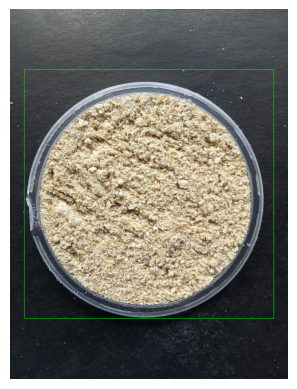

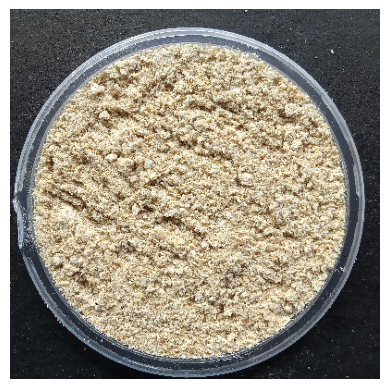

(400, 400, 3)


In [ ]:
# Convert BGR to RGB for Matplotlib display
# img_rgb = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)

# print(img_rgb.shape)

# target_size = 2800
# pos = 2

# # Draw triangle in the image
# cv2.rectangle(img_rgb, ((img_rgb.shape[1] - target_size) // pos, (img_rgb.shape[0] - target_size) // pos), ((img_rgb.shape[1] + target_size) // pos, (img_rgb.shape[0] + target_size) // pos), (0, 255, 0), 3)

# # Display the image with aspect ratio preserved and no axes
# plt.imshow(img_rgb)
# plt.axis('off')
# plt.show()

# Convert BGR to RGB for Matplotlib display
img_rgb = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)

print(img_rgb.shape)

target_size = 2800
pos = 2

# Define the rectangle coordinates
x1 = (img_rgb.shape[1] - target_size) // pos
y1 = (img_rgb.shape[0] - target_size) // pos
x2 = (img_rgb.shape[1] + target_size) // pos
y2 = (img_rgb.shape[0] + target_size) // pos

# Draw rectangle in the image
cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Extract the region of interest (ROI) within the rectangle
roi = img_rgb[y1:y2, x1:x2]

# Resize the ROI to 400x400
resized_roi = cv2.resize(roi, (400, 400))

# Save the resized ROI
cv2.imwrite('resized_roi2.jpg', cv2.cvtColor(resized_roi, cv2.COLOR_RGB2BGR))

# Display the original image with the rectangle
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Display the resized ROI
plt.imshow(resized_roi)
plt.axis('off')
plt.show()

print(resized_roi.shape)


## Start of the Training Process

In [ ]:
# Define the base directory
#base_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Program\\Dataset Images\\Raw\\Rice Bran\\Training and Validation'
#base_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Program\\Dataset Images\\Rice Bran\\Raw'
base_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Set 2/Training and Validation'

# Define the subdirectories for each type
pure_rb_dir = os.path.join(base_dir, 'Pure')
adulterated_rb_dir = os.path.join(base_dir, 'Adulterated')

image_path = os.path.join(pure_rb_dir, 'pure_rb_1 (11).jpg')
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


## DATA SPLITTING

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='training',
    label_mode='binary',
    image_size=(400, 400),
    batch_size=32,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='validation',
    label_mode='binary',
    image_size=(400, 400),
    batch_size=32,
)

class_names = train_ds.class_names
print(class_names)

Found 4000 files belonging to 2 classes.
Using 2800 files for training.
Found 4000 files belonging to 2 classes.
Using 1200 files for validation.
['Adulterated', 'Pure']


## TRAINING PROCESS WITH DIFFERENT TYPES OF CNN ARCHITECTURE

In [25]:
# number of epochs
epoch = 10
start = timer()

# Custom CNN Model
custom_model = cnn.CustomModel()
custom_model.compile(optimizer=Adam(learning_rate=0.00001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

custom_model_history = custom_model.fit(x = train_ds, validation_data=validation_ds, epochs=epoch)
print('Total Time consumed for ' + str(epoch) + ' --->', timer()-start)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 24,584,193 (93.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
# ResNet50 Model
resnet_model = cnn.ResNetModel()
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.fit(x = train_ds, validation_data=validation_ds, epochs=epoch)

# Fine-tuning (Unfreeze Top Layers)
pretrained_model = resnet_model.layers[0] # Get the ResNet50 model

# Unfreeze some top layers (experiment with the number)
for layer in pretrained_model.layers[100:]:  # Unfreeze from layer 100 onwards (adjust)
    layer.trainable = True

# Important: Recompile the model after changing trainable status
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),  # Very low learning rate for fine-tuning
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

resnet50_model_history = resnet_model.fit(x = train_ds, validation_data=validation_ds, epochs=epoch)
print('Total Time consumed for ' + str(epoch) + ' epoch/s --->', timer()-start)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 113s 413ms/step - accuracy: 0.5520 - loss: 0.9256 - val_accuracy: 0.4925 - val_loss: 1.4834
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 397ms/step - accuracy: 0.8167 - loss: 0.4149 - val_accuracy: 0.5850 - val_loss: 1.1151
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 398ms/step - accuracy: 0.8756 - loss: 0.2938 - val_accuracy: 0.5342 - val_loss: 2.9330
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 399ms/step - accuracy: 0.8949 - loss: 0.2460 - val_accuracy: 0.5800 - val_loss: 4.3233
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 399ms/step - accuracy: 0.9461 - loss: 0.1439 - val_accuracy: 0.9333 - val_loss: 0.2344
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 399ms/step - accuracy: 0.9312 - loss: 0.1842 - val_accuracy: 0.8192 - val_loss: 0.8627
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 400ms/step - accuracy: 0.9591 - loss: 0.1021 - val_accuracy: 0.6817 - val_loss: 2.5350
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 400ms/step - accuracy: 0.9745 - loss: 

## EVALUATING TRAINING MODEL

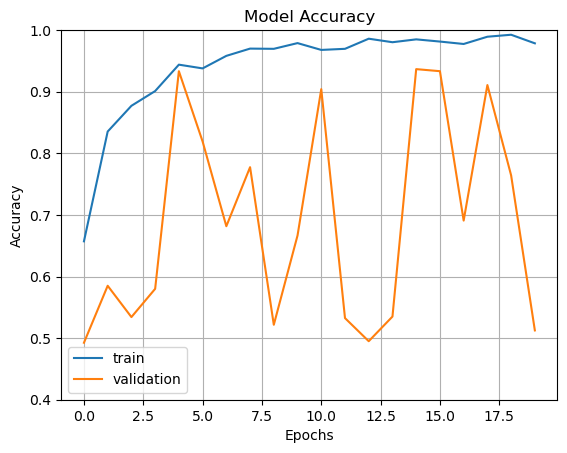

In [27]:
fig_one = plt.gcf()

# Model Accuracy
plt.plot(resnet50_model_history.history['accuracy'])
plt.plot(resnet50_model_history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

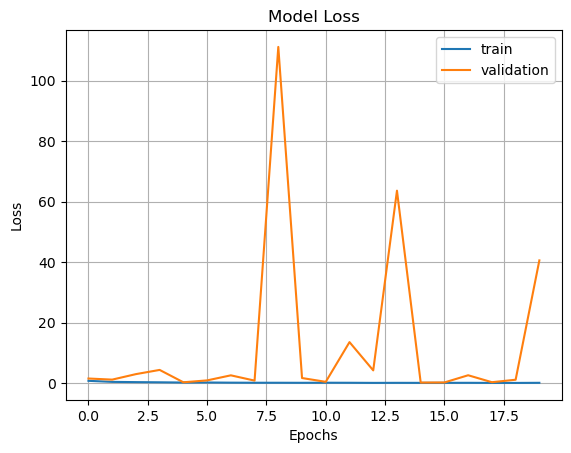

In [28]:
# Model Loss
plt.plot(resnet50_model_history.history['loss'])
plt.plot(resnet50_model_history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## TESTING THE MODEL

In [29]:
# Testing Dataset Directory
test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(500, 500),
    batch_size=16,
    label_mode='binary'
)

Found 645 files belonging to 2 classes.


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.4682 - loss: 40.6078
Test Loss: 37.90842056274414
Test Accuracy: 0.4883720874786377


2025-02-04 23:28:28.104703: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.00      0.00      0.00       330
        Pure       0.49      1.00      0.66       315

    accuracy                           0.49       645
   macro avg       0.24      0.50      0.33       645
weighted avg       0.24      0.49      0.32       645

Precision: 0.4883720930232558
Recall: 1.0
F1 Score: 0.65625


/home/cs_root/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cs_root/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cs_root/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


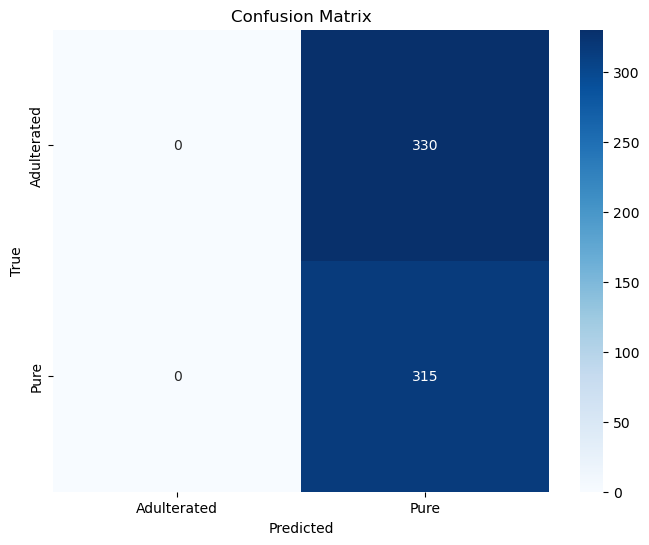

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = resnet_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)  # For binary classification

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Save the Model

In [12]:
# Save the entire model
resnet_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/rb_resnet_1.h5')

In [23]:
# test sample image

# Step 1: Load the saved model
loaded_model = load_model('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/rb_resnet_1.h5')

# Step 2: Verify the loaded model
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f'Test Loss (Loaded Model): {test_loss}')
print(f'Test Accuracy (Loaded Model): {test_accuracy}')

# Step 3: Make predictions on new data
#img_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Pure/pure_rb (1).jpg'
img_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Adulterated/adulterated_rb (1).jpg'
img = image.load_img(img_path, target_size=(500, 500))  # Resize to match model input size
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values (if required)

# Make a prediction
prediction = loaded_model.predict(img_array)

# For binary classification, convert probabilities to class labels
if prediction > 0.5:
    print("Predicted Class: Pure")
else:
    print("Predicted Class: Adulterated")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.5042 - loss: 2.9512
Test Loss (Loaded Model): 2.832855463027954
Test Accuracy (Loaded Model): 0.5147286653518677


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Pure
